In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_31664/2889067548.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
# Importing Required Libraries

# Import the MNIST dataset from torchvision
import torchvision

# Import numpy for data manipulation
import numpy as np

# Load the MNIST dataset and download it if necessary
MNIST = torchvision.datasets.MNIST(".", download=True)

# Extract the training data, training labels, test data, and test labels from the MNIST dataset
train_data = MNIST.train_data
train_labels = MNIST.train_labels
test_data = MNIST.test_data
test_labels = MNIST.test_labels

# Combining and Subsampling Data

# Vertically combine the training and test data arrays
data = np.vstack([train_data, test_data])

# Vertically combine the training and test labels arrays
labels = np.hstack([train_labels, test_labels])

# Set a random seed for reproducibility
np.random.seed(42)

# Randomly select 20,000 samples from the combined data without replacement
indices = np.random.choice(len(data), size=20000, replace=False)

# Update the 'data' array to include only the selected samples
data = data[indices]

# Update the 'labels' array to include only the labels corresponding to the selected samples
labels = labels[indices]

# Reshape the 'data' array to ensure it is a 2D array
data = data.reshape(data.shape[0], -1)

# Explanation:
# This code imports the MNIST dataset using torchvision and extracts the training and test data along with their labels.
# It then vertically combines the training and test data arrays, as well as the labels arrays, to create a larger dataset.
# Randomly, 20,000 samples are selected from the combined dataset without replacement to reduce its size.
# Finally, both the 'data' and 'labels' arrays are reshaped into 2D arrays, which is a common format for input to machine learning models.


/home/yifei/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/yifei/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/yifei/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/yifei/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [3]:
# Set a random seed for reproducibility
np.random.seed(42)

# Randomly select 20,000 samples from the combined data without replacement
indices = np.random.choice(len(data), size=20000, replace=False)

# Update the 'data' array to include only the selected samples
data = data[indices]

# Update the 'labels' array to include only the labels corresponding to the selected samples
labels = labels[indices]

# Reshape the 'data' array to ensure it is a 2D array
data = data.reshape(data.shape[0], -1)

# Reshape the 'labels' array to ensure it is a 2D array
labels = labels.reshape(labels.shape[0], -1)

# Explanation:
# This code combines the training and test datasets and labels to create a larger dataset for analysis.
# It then randomly selects 20,000 samples from the combined dataset without replacement, ensuring randomness and diversity.
# The 'data' and 'labels' arrays are updated to contain only the selected samples.
# Finally, both the 'data' and 'labels' arrays are reshaped into 2D arrays, which is a common format for input to machine learning models.


In [4]:
data = np.concatenate((labels, data),axis=1)

In [5]:
# import dataset (comes with colab!)


# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# Scramble the images

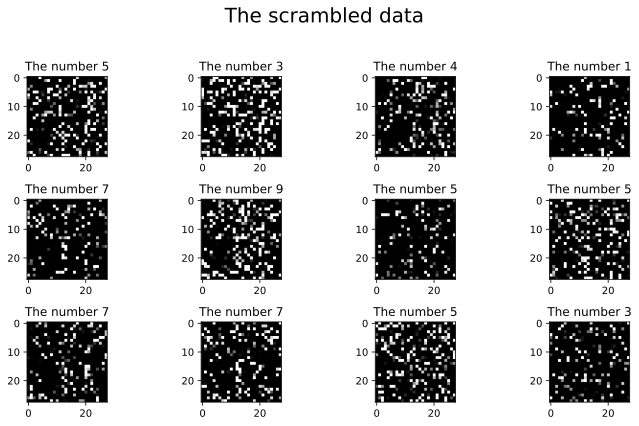

In [6]:
# randomly scramble the data,
# preserving the re-ordering for each image
eggs = np.random.permutation(data.shape[1])
scrambled = dataNorm[:,eggs]


# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0,high=data.shape[0])

  # create the image (must be reshaped!)
  img = np.reshape(scrambled[randimg2show,:],(28,28))
  ax.imshow(img,cmap='gray')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('The scrambled data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

# Create train/test groups using DataLoader

In [7]:
# Step 1: convert to tensor
dataT   = torch.tensor( scrambled ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [8]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
      # NOTE: no log-softmax above because of the loss function below
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# Create a function that trains the model

In [9]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader))
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [10]:
trainAcc,testAcc,losses,net = function2trainTheModel()


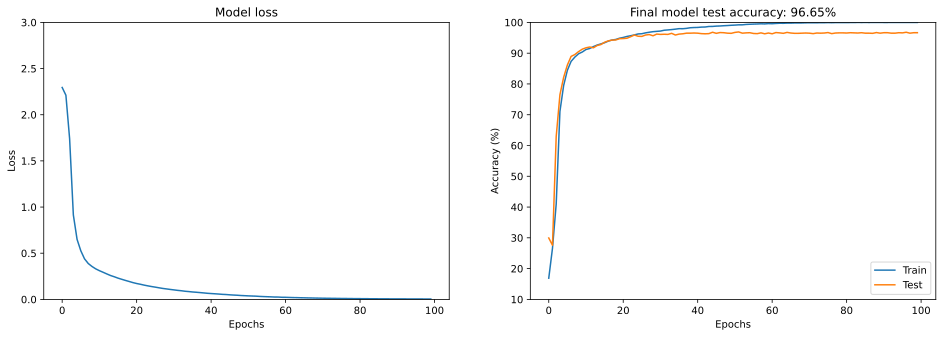

In [11]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

### Reflection:
1. Scrambled data doesn't affect FFN model since ANN & FFN is to predict from the data regradless of how we human interpret this data, as long as all same category data is transform in the same way. So technically it's learning from pattern